# Road sign detection with YOLOv8

### Reference

[1] [[Github](https://github.com/ultralytics/ultralytics)] [[Docs](https://docs.ultralytics.com/ko/)] YOLOv8

[2] [[kaggle](https://www.kaggle.com/datasets/andrewmvd/road-sign-detection)] Road Sign Detection

### Settings
- Create and activate virtual environment
    - conda create -n yolov8 python==3.10
    - conda activate yolov8

- Install library
    - pip install torch torchvision
    - pip install ultralytics

In [1]:
# gpu 사용 여부 확인
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# 설치 확인
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.1.22 🚀 Python-3.10.0 torch-2.2.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4070, 12282MiB)
Setup complete ✅ (28 CPUs, 63.8 GB RAM, 284.5/1862.1 GB disk)


### Data preparation

- Download the data [[링크](https://www.kaggle.com/datasets/andrewmvd/road-sign-detection)]
- Directory

    ```
    road_sign_detection.ipynb               
    └── road_sign_detection     # Dataset   
        └── images                          
        └── annotations                     
    ```   
- Annotation convert (Pascal VOC to YOLO)

In [2]:
import xml.etree.ElementTree as ET
import glob
import os
import json
from tqdm import tqdm

In [3]:
def xml_to_yolo_bbox(bbox, w, h):
    # xmin, ymin, xmax, ymax
    x_center = ((bbox[2] + bbox[0]) / 2) / w
    y_center = ((bbox[3] + bbox[1]) / 2) / h
    width = (bbox[2] - bbox[0]) / w
    height = (bbox[3] - bbox[1]) / h
    return [x_center, y_center, width, height]

In [4]:
road_sign_root = "road_sign_detection/"
annot_path = os.path.join(road_sign_root,"annotations")
img_path = os.path.join(road_sign_root,"images")
label_path = os.path.join(road_sign_root,"labels")

if not os.path.exists(label_path):
    os.makedirs(label_path)

In [5]:
classes = []

files = glob.glob(os.path.join(annot_path, '*.xml'))
for fil in tqdm(files):

    basename = os.path.basename(fil)
    filename = os.path.splitext(basename)[0]

    result = []

    tree = ET.parse(fil)
    root = tree.getroot()
    width = int(root.find("size").find("width").text)
    height = int(root.find("size").find("height").text)
    for obj in root.findall('object'):
        label = obj.find("name").text
        if label not in classes:
            classes.append(label)
        index = classes.index(label)
        pil_bbox = [int(x.text) for x in obj.find("bndbox")]
        yolo_bbox = xml_to_yolo_bbox(pil_bbox, width, height)
        bbox_string = " ".join([str(x) for x in yolo_bbox])
        result.append(f"{index} {bbox_string}")
    if result:
        with open(os.path.join(label_path, f"{filename}.txt"), "w", encoding="utf-8") as f:
            f.write("\n".join(result))

100%|██████████| 877/877 [00:00<00:00, 2933.11it/s]


### Split data (train and test)

In [8]:
import os
import random
from shutil import copyfile, rmtree

road_sign_path = "road_sign_detection/"
label_ = '.txt'
img_ = '.png'

# 저장 경로 만들기
folder_list = ['road_sign_detection/train', 'road_sign_detection/val', 'road_sign_detection/train/images', \
                'road_sign_detection/train/labels', 'road_sign_detection/val/images', 'road_sign_detection/val/labels']
for folder in folder_list:
    if not os.path.exists(folder):
        os.makedirs(folder)

In [9]:
file_list = os.listdir(os.path.join(road_sign_path, 'images'))

random.shuffle(file_list)

test_ratio = 0.1
test_list = file_list[:int(len(file_list)*test_ratio)]
train_list = file_list[int(len(file_list)*test_ratio):]

print(f"train의 개수 : {len(train_list)}, test의 개수 : {len(test_list)}")

for i in test_list:
  f_name = os.path.splitext(i)[0]
  copyfile(os.path.join(road_sign_path, 'images', (f_name+img_)), os.path.join(road_sign_path, 'val/images', (f_name+img_)))
  copyfile(os.path.join(road_sign_path, 'labels', (f_name+label_)), os.path.join(road_sign_path, 'val/labels', (f_name+label_)))
for i in train_list:
  f_name = os.path.splitext(i)[0]
  copyfile(os.path.join(road_sign_path, 'images', (f_name+img_)), os.path.join(road_sign_path, 'train/images', (f_name+img_)))
  copyfile(os.path.join(road_sign_path, 'labels', (f_name+label_)), os.path.join(road_sign_path, 'train/labels', (f_name+label_)))

train의 개수 : 790, test의 개수 : 87


### Create config file
- Set as an absolute path

    data['train'] = 'road_sign_detection/train'

    data['val']   = 'road_sign_detection/val'

    data['test']  = 'road_sign_detection/val'

In [12]:
import yaml
data =dict()

data['train'] = 
data['val']   = 
data['test']  = 

data['nc'] = 4
data['names'] =['Trafic_light','Speedlimit', 'Crosswalk','Stop']

with open('road_sign.yaml', 'w') as f:
	yaml.dump(data, f)

### Model train

In [13]:
from ultralytics import YOLO
model = YOLO('yolov8s.yaml')
results = model.train(data ='road_sign.yaml', 
                      epochs = 100, 
                      batch=32,
                      device = 0, 
                      patience=30, 
                      name='road_sign_1')

New https://pypi.org/project/ultralytics/8.1.23 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.22 🚀 Python-3.10.0 torch-2.2.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4070, 12282MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.yaml, data=road_sign.yaml, epochs=100, time=None, patience=30, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=road_sign_12, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False,

train: Scanning C:\Users\jyes9\Desktop\PROJECT\github\open_source\object_detection\road_sign_detection\train\labels... 875 images, 0 backgrounds, 0 corrupt: 100%|██████████| 875/875 [00:00<00:00, 2292.24it/s]

train: New cache created: C:\Users\jyes9\Desktop\PROJECT\github\open_source\object_detection\road_sign_detection\train\labels.cache



val: Scanning C:\Users\jyes9\Desktop\PROJECT\github\open_source\object_detection\road_sign_detection\val\labels... 172 images, 0 backgrounds, 0 corrupt: 100%|██████████| 172/172 [00:00<00:00, 1525.66it/s]

val: New cache created: C:\Users\jyes9\Desktop\PROJECT\github\open_source\object_detection\road_sign_detection\val\labels.cache


Plotting labels to runs\detect\road_sign_12\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\road_sign_12
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100       7.4G      3.639      5.281      4.273         38        640: 100%|██████████| 28/28 [00:07<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.29it/s]

                   all        172        251    0.00032      0.123   0.000478   0.000103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      7.47G      3.118      4.237      3.719         22        640: 100%|██████████| 28/28 [00:06<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.89it/s]

                   all        172        251   0.000451      0.125   0.000733   0.000184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      7.47G      2.575      3.338      3.078         35        640: 100%|██████████| 28/28 [00:06<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.04it/s]

                   all        172        251   0.000442      0.081       0.02    0.00712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      7.47G      2.134      2.484      2.525         31        640: 100%|██████████| 28/28 [00:06<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.51it/s]

                   all        172        251      0.712      0.126      0.163     0.0937



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      7.47G      1.776      1.958      2.134         22        640: 100%|██████████| 28/28 [00:06<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.83it/s]

                   all        172        251      0.842       0.36      0.466      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      7.47G      1.563      1.608      1.951         41        640: 100%|██████████| 28/28 [00:06<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.68it/s]

                   all        172        251      0.878        0.4       0.56      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      7.47G       1.38       1.36      1.731         33        640: 100%|██████████| 28/28 [00:06<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.74it/s]

                   all        172        251      0.801      0.433      0.505      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      7.48G      1.281      1.226      1.648         32        640: 100%|██████████| 28/28 [00:06<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.76it/s]

                   all        172        251      0.893      0.541      0.631      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      7.47G      1.168      1.117      1.537         27        640: 100%|██████████| 28/28 [00:06<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.74it/s]

                   all        172        251      0.804      0.522      0.613      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      7.47G      1.196      1.094      1.553         28        640: 100%|██████████| 28/28 [00:06<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.77it/s]

                   all        172        251      0.769      0.619        0.7      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      7.47G       1.15      1.043      1.532         41        640: 100%|██████████| 28/28 [00:06<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.72it/s]

                   all        172        251      0.714      0.699      0.727      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      7.47G      1.047     0.9379      1.409         34        640: 100%|██████████| 28/28 [00:06<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.77it/s]

                   all        172        251      0.879      0.639      0.733       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      7.47G      1.053     0.9747      1.421         31        640: 100%|██████████| 28/28 [00:06<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.72it/s]

                   all        172        251      0.768      0.683      0.767      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      7.48G     0.9953     0.9236      1.356         27        640: 100%|██████████| 28/28 [00:06<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.75it/s]

                   all        172        251       0.83      0.709      0.778      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      7.47G     0.9888      0.916      1.356         30        640: 100%|██████████| 28/28 [00:06<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.78it/s]

                   all        172        251      0.752      0.781      0.794      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      7.47G     0.9774      0.852      1.331         26        640: 100%|██████████| 28/28 [00:06<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.76it/s]

                   all        172        251      0.797      0.754      0.797      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      7.47G     0.9424     0.7891      1.312         15        640: 100%|██████████| 28/28 [00:06<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.75it/s]

                   all        172        251      0.837      0.758      0.832      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      7.47G     0.9262     0.7794      1.287         35        640: 100%|██████████| 28/28 [00:06<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.79it/s]

                   all        172        251      0.878      0.684      0.806      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      7.47G     0.8861     0.7356      1.238         31        640: 100%|██████████| 28/28 [00:06<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.50it/s]

                   all        172        251      0.763      0.762      0.827      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      7.48G      0.888     0.7469      1.251         35        640: 100%|██████████| 28/28 [00:06<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.70it/s]

                   all        172        251       0.82      0.809      0.834      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      7.47G     0.8702     0.7265      1.223         27        640: 100%|██████████| 28/28 [00:06<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.83it/s]

                   all        172        251      0.918      0.799      0.871      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      7.47G     0.8571     0.6794      1.214         28        640: 100%|██████████| 28/28 [00:06<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.84it/s]

                   all        172        251      0.871      0.836      0.897      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      7.47G     0.8741     0.7281      1.231         22        640: 100%|██████████| 28/28 [00:06<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.86it/s]

                   all        172        251      0.863      0.873      0.885      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      7.47G     0.8316      0.681      1.204         21        640: 100%|██████████| 28/28 [00:06<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.64it/s]

                   all        172        251      0.853      0.706       0.75      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      7.47G     0.8287      0.673       1.21         27        640: 100%|██████████| 28/28 [00:06<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.71it/s]

                   all        172        251      0.839       0.88      0.899      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      7.48G     0.8195     0.6606      1.177         26        640: 100%|██████████| 28/28 [00:06<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.55it/s]

                   all        172        251       0.88      0.841       0.91      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      7.47G     0.8231     0.6517      1.169         25        640: 100%|██████████| 28/28 [00:06<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.77it/s]

                   all        172        251      0.867      0.867      0.915      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      7.47G     0.8196     0.6259      1.188         30        640: 100%|██████████| 28/28 [00:06<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.70it/s]

                   all        172        251      0.859      0.865      0.902      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      7.47G     0.7887     0.5992      1.171         34        640: 100%|██████████| 28/28 [00:06<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.78it/s]

                   all        172        251      0.887        0.8      0.893      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      7.47G     0.7663     0.5964      1.133         40        640: 100%|██████████| 28/28 [00:06<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.76it/s]

                   all        172        251       0.91      0.811      0.907      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      7.47G     0.7793     0.5823      1.127         31        640: 100%|██████████| 28/28 [00:06<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.35it/s]

                   all        172        251      0.888      0.858      0.903      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      7.48G     0.7667     0.5751      1.136         17        640: 100%|██████████| 28/28 [00:06<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.88it/s]

                   all        172        251      0.914      0.911      0.935      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      7.47G     0.7805     0.5922      1.148         29        640: 100%|██████████| 28/28 [00:06<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.05it/s]

                   all        172        251        0.9      0.887      0.923      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      7.47G     0.7699     0.5915      1.134         38        640: 100%|██████████| 28/28 [00:06<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.00it/s]

                   all        172        251      0.957      0.868      0.939      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      7.47G     0.7613     0.5819      1.133         22        640: 100%|██████████| 28/28 [00:06<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.72it/s]

                   all        172        251      0.969      0.888      0.939      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      7.47G      0.764     0.5601       1.15         20        640: 100%|██████████| 28/28 [00:06<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.00it/s]

                   all        172        251      0.957      0.904      0.955      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      7.47G     0.7659     0.5645      1.135         18        640: 100%|██████████| 28/28 [00:05<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.04it/s]

                   all        172        251      0.952       0.89      0.945      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      7.48G     0.7371     0.5498      1.112         24        640: 100%|██████████| 28/28 [00:06<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.85it/s]

                   all        172        251      0.915      0.908      0.936      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      7.47G     0.7333     0.5349      1.105         19        640: 100%|██████████| 28/28 [00:06<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.01it/s]

                   all        172        251      0.926      0.925      0.951      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      7.46G     0.7323     0.5297      1.109         17        640: 100%|██████████| 28/28 [00:06<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.02it/s]

                   all        172        251      0.914      0.932      0.951      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      7.47G     0.7088     0.5234      1.104         31        640: 100%|██████████| 28/28 [00:06<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.82it/s]

                   all        172        251      0.942      0.933       0.96      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      7.47G     0.7041     0.5221      1.091         35        640: 100%|██████████| 28/28 [00:06<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.06it/s]

                   all        172        251      0.944      0.928      0.949      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      7.47G      0.701       0.51      1.087         27        640: 100%|██████████| 28/28 [00:06<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.95it/s]

                   all        172        251       0.96      0.921      0.962      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      7.48G      0.711     0.5205      1.102         23        640: 100%|██████████| 28/28 [00:06<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.72it/s]

                   all        172        251      0.908      0.909      0.945      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      7.46G     0.7235     0.5213      1.107         37        640: 100%|██████████| 28/28 [00:06<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.78it/s]

                   all        172        251      0.948      0.916       0.95      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      7.47G     0.6957     0.4958      1.076         23        640: 100%|██████████| 28/28 [00:06<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.99it/s]

                   all        172        251      0.948      0.935      0.965      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      7.47G     0.6949     0.4875      1.084         35        640: 100%|██████████| 28/28 [00:05<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.03it/s]

                   all        172        251       0.95      0.937      0.967      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      7.47G     0.7004      0.499      1.082         34        640: 100%|██████████| 28/28 [00:06<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.63it/s]

                   all        172        251      0.969      0.906      0.954      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      7.47G     0.6954     0.4962      1.078         25        640: 100%|██████████| 28/28 [00:06<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.83it/s]

                   all        172        251      0.926      0.945      0.955      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      7.48G     0.6854     0.4977      1.087         28        640: 100%|██████████| 28/28 [00:05<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.86it/s]

                   all        172        251      0.923      0.955      0.966       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      7.47G      0.679     0.4857      1.069         27        640: 100%|██████████| 28/28 [00:05<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.02it/s]

                   all        172        251      0.974       0.87      0.955      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      7.47G     0.6842     0.4767       1.07         27        640: 100%|██████████| 28/28 [00:05<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.00it/s]

                   all        172        251      0.952      0.951      0.964      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      7.47G     0.6701     0.4558      1.049         33        640: 100%|██████████| 28/28 [00:05<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.05it/s]

                   all        172        251      0.971      0.937      0.972      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      7.47G     0.6535     0.4566      1.051         23        640: 100%|██████████| 28/28 [00:06<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.94it/s]

                   all        172        251      0.964      0.937       0.97      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      7.47G     0.6491     0.4489      1.032         26        640: 100%|██████████| 28/28 [00:06<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.85it/s]

                   all        172        251      0.971      0.929       0.97      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      7.48G     0.6573     0.4654      1.046         32        640: 100%|██████████| 28/28 [00:06<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.85it/s]

                   all        172        251      0.965      0.939      0.973      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      7.47G     0.6365     0.4447      1.037         35        640: 100%|██████████| 28/28 [00:06<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.84it/s]

                   all        172        251      0.969      0.944      0.977      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      7.47G      0.653     0.4544      1.039         26        640: 100%|██████████| 28/28 [00:06<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.88it/s]

                   all        172        251       0.97      0.955      0.978      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      7.47G     0.6419      0.454      1.042         36        640: 100%|██████████| 28/28 [00:06<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.77it/s]

                   all        172        251      0.972      0.943      0.977      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      7.47G     0.6396     0.4371      1.034         23        640: 100%|██████████| 28/28 [00:06<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.80it/s]

                   all        172        251      0.964      0.962      0.983      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      7.47G     0.6524      0.444       1.05         31        640: 100%|██████████| 28/28 [00:06<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.81it/s]

                   all        172        251       0.97      0.942      0.979      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      7.48G     0.6318     0.4227      1.028         40        640: 100%|██████████| 28/28 [00:06<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.80it/s]

                   all        172        251      0.957      0.963      0.979      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      7.47G     0.6459     0.4345      1.035         23        640: 100%|██████████| 28/28 [00:06<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.78it/s]

                   all        172        251      0.963       0.96      0.978       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      7.47G     0.6281     0.4342      1.035         37        640: 100%|██████████| 28/28 [00:06<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.82it/s]

                   all        172        251      0.964      0.953       0.98      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      7.47G     0.6485     0.4308      1.034         24        640: 100%|██████████| 28/28 [00:06<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.78it/s]

                   all        172        251      0.979      0.946      0.982      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      7.47G     0.6444     0.4218      1.033         36        640: 100%|██████████| 28/28 [00:06<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.95it/s]

                   all        172        251      0.955      0.961      0.981      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      7.47G      0.629     0.4288      1.032         32        640: 100%|██████████| 28/28 [00:06<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.67it/s]

                   all        172        251      0.984      0.958      0.983       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      7.48G     0.6215     0.4131      1.028         28        640: 100%|██████████| 28/28 [00:06<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.70it/s]

                   all        172        251      0.988      0.964      0.981      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      7.47G     0.6089     0.4253      1.025         19        640: 100%|██████████| 28/28 [00:06<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.65it/s]

                   all        172        251      0.983      0.935       0.98      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      7.47G      0.615     0.4142      1.035         23        640: 100%|██████████| 28/28 [00:06<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]

                   all        172        251      0.984      0.955      0.983      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      7.47G     0.6033     0.4047      1.018         41        640: 100%|██████████| 28/28 [00:06<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.00it/s]

                   all        172        251      0.937      0.971      0.978      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      7.47G     0.5936     0.3948      1.006         28        640: 100%|██████████| 28/28 [00:06<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.03it/s]

                   all        172        251      0.987       0.94      0.984      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      7.47G     0.6051     0.4019      1.006         33        640: 100%|██████████| 28/28 [00:06<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.63it/s]

                   all        172        251      0.981       0.94      0.976      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      7.48G     0.6184     0.4071      1.023         30        640: 100%|██████████| 28/28 [00:06<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.97it/s]

                   all        172        251      0.972      0.971      0.982      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      7.47G     0.6118     0.4072      1.017         25        640: 100%|██████████| 28/28 [00:06<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.80it/s]

                   all        172        251      0.982       0.96       0.98      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      7.47G     0.5932     0.3961      1.009         29        640: 100%|██████████| 28/28 [00:06<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]

                   all        172        251      0.973      0.962      0.984       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      7.47G     0.5908     0.3874      1.002         21        640: 100%|██████████| 28/28 [00:06<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.88it/s]

                   all        172        251      0.991      0.956      0.985      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      7.47G     0.5744     0.3813      1.004         25        640: 100%|██████████| 28/28 [00:06<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.02it/s]

                   all        172        251      0.976      0.967      0.982      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      7.47G     0.5775     0.3846     0.9949         19        640: 100%|██████████| 28/28 [00:06<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.85it/s]

                   all        172        251      0.983      0.961      0.984      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      7.48G     0.5745     0.3762      1.003         29        640: 100%|██████████| 28/28 [00:06<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.95it/s]

                   all        172        251       0.99      0.967      0.986      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      7.47G     0.5796     0.3839      1.004         22        640: 100%|██████████| 28/28 [00:06<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.97it/s]

                   all        172        251      0.972      0.952      0.984      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      7.47G     0.5706     0.3806      1.013         26        640: 100%|██████████| 28/28 [00:06<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.98it/s]

                   all        172        251      0.992      0.965      0.985      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      7.47G      0.577     0.3757     0.9902         29        640: 100%|██████████| 28/28 [00:06<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.00it/s]

                   all        172        251      0.988      0.964      0.986      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      7.47G     0.5775     0.3805     0.9995         28        640: 100%|██████████| 28/28 [00:06<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.97it/s]

                   all        172        251      0.986      0.947      0.982      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      7.47G      0.586     0.3748     0.9939         26        640: 100%|██████████| 28/28 [00:06<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.93it/s]

                   all        172        251      0.989      0.967      0.983      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      7.48G     0.5658     0.3679     0.9952         30        640: 100%|██████████| 28/28 [00:06<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.99it/s]

                   all        172        251      0.986      0.954      0.984      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      7.46G      0.565     0.3679     0.9902         28        640: 100%|██████████| 28/28 [00:06<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.05it/s]

                   all        172        251      0.967      0.984      0.986      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      7.47G     0.5627     0.3644     0.9778         23        640: 100%|██████████| 28/28 [00:06<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.04it/s]

                   all        172        251       0.98      0.979      0.983      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      7.47G     0.5649     0.3656     0.9823         30        640: 100%|██████████| 28/28 [00:06<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.97it/s]

                   all        172        251      0.974      0.982      0.985      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      7.47G     0.5454     0.3482     0.9752         33        640: 100%|██████████| 28/28 [00:06<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.93it/s]

                   all        172        251       0.99      0.965       0.99      0.882


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      7.47G     0.5151     0.3251     0.9608         14        640: 100%|██████████| 28/28 [00:06<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.88it/s]

                   all        172        251      0.967      0.974      0.985      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      7.48G     0.5199     0.3099     0.9553         17        640: 100%|██████████| 28/28 [00:06<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.94it/s]

                   all        172        251      0.993      0.972       0.99      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      7.47G     0.5042     0.3058     0.9455         18        640: 100%|██████████| 28/28 [00:06<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.95it/s]

                   all        172        251       0.97      0.988       0.99      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      7.48G     0.4972     0.3036     0.9386         13        640: 100%|██████████| 28/28 [00:06<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.82it/s]

                   all        172        251      0.986      0.977       0.99      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      7.47G     0.4923     0.2965     0.9343         14        640: 100%|██████████| 28/28 [00:06<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.98it/s]

                   all        172        251      0.987      0.967       0.99      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      7.48G      0.493     0.2996     0.9472         14        640: 100%|██████████| 28/28 [00:06<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.99it/s]

                   all        172        251      0.967      0.991       0.99      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      7.48G     0.4964     0.3029     0.9436         13        640: 100%|██████████| 28/28 [00:06<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.02it/s]

                   all        172        251      0.984      0.984       0.99      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      7.48G     0.4837     0.2918     0.9303         15        640: 100%|██████████| 28/28 [00:06<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.93it/s]

                   all        172        251      0.966       0.99       0.99      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      7.47G     0.4916     0.2906     0.9348         17        640: 100%|██████████| 28/28 [00:06<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.01it/s]

                   all        172        251      0.989       0.98      0.991      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      7.48G      0.484     0.2885     0.9334         15        640: 100%|██████████| 28/28 [00:06<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.90it/s]

                   all        172        251      0.989      0.981      0.991      0.897



100 epochs completed in 0.202 hours.
Optimizer stripped from runs\detect\road_sign_12\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\road_sign_12\weights\best.pt, 22.5MB

Validating runs\detect\road_sign_12\weights\best.pt...
Ultralytics YOLOv8.1.22 🚀 Python-3.10.0 torch-2.2.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4070, 12282MiB)
YOLOv8s summary (fused): 168 layers, 11127132 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.96it/s]


                   all        172        251      0.989      0.981      0.991      0.897
          Trafic_light        172         33      0.988          1      0.995      0.882
            Speedlimit        172        145      0.989      0.993      0.989      0.924
             Crosswalk        172         52       0.98      0.939      0.983      0.841
                  Stop        172         21          1      0.994      0.995      0.942
Speed: 0.1ms preprocess, 2.0ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs\detect\road_sign_12


### Test

- Check path after training: ``` Results saved to "path" ```

In [14]:
from ultralytics import YOLO

# Load a model
model_path = "runs/detect/road_sign_12/weights/best.pt"
model = YOLO(model_path)  # load a custom model

# Validate the model
metrics = model.val()  # no arguments needed, dataset and settings remembered

print("map50-95", metrics.box.map)
print("map50", metrics.box.map50)

Ultralytics YOLOv8.1.22 🚀 Python-3.10.0 torch-2.2.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4070, 12282MiB)
YOLOv8s summary (fused): 168 layers, 11127132 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning C:\Users\jyes9\Desktop\PROJECT\github\open_source\object_detection\road_sign_detection\val\labels.cache... 172 images, 0 backgrounds, 0 corrupt: 100%|██████████| 172/172 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.01it/s]


                   all        172        251       0.99      0.981      0.991      0.899
          Trafic_light        172         33      0.989          1      0.995      0.889
            Speedlimit        172        145      0.989      0.993      0.989      0.923
             Crosswalk        172         52       0.98      0.939      0.983      0.844
                  Stop        172         21          1      0.994      0.995      0.939
Speed: 0.4ms preprocess, 3.7ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs\detect\val3
map50-95 0.899063868997963
map50 0.9905632975228906


### Inference

In [17]:
from ultralytics import YOLO
import cv2
import os
from ultralytics.utils.plotting import Annotator
import matplotlib.pyplot as plt
import numpy as np

In [21]:
model_path = "runs/detect/road_sign_12/weights/best.pt"
model = YOLO(model_path)

root_folder = 'road_sign_detection/val/images/'
result_folder = 'road_sign_detection/result'
if not os.path.exists(result_folder):
    os.makedirs(result_folder)

test_img_list = os.listdir(root_folder)

device = 'cpu'
color_dict = [(0, 255, 0),(255, 255, 0),(0, 0, 255), (255, 0,0)]
color_dict_2 = [(0, 0, 0),(0, 0, 0),(255, 255, 255), (255, 255,255)]


0: 480x640 1 Trafic_light, 58.2ms
Speed: 12.0ms preprocess, 58.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


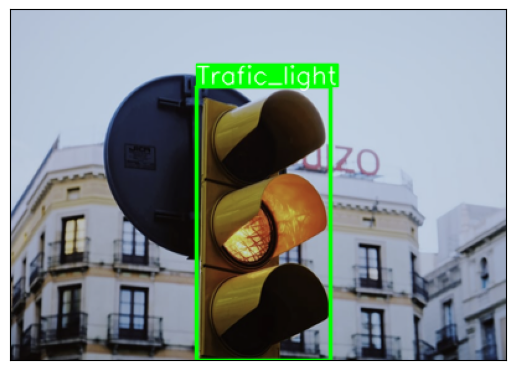

In [57]:
test_img = cv2.imread(os.path.join(root_folder, test_img_list[0]))
img_src = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
results = model(test_img)
for result in results:
    annotator = Annotator(img_src)
    boxes = result.boxes
    for box in boxes:
        b = box.xyxy[0]  # get box coordinates in (top, left, bottom, right) format
        cls = box.cls
        annotator.box_label(b, model.names[int(cls)], color_dict[int(cls)])
img_src = annotator.result()

%matplotlib inline
plt.imshow(img_src)
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)
plt.show()

In [53]:
for idx , file in enumerate(test_img_list):
    test_img = cv2.imread(os.path.join(root_folder, file))
    img_src = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    results = model(test_img)

    for result in results:
        annotator = Annotator(img_src)
        boxes = result.boxes
        for box in boxes:
            b = box.xyxy[0]  # get box coordinates in (top, left, bottom, right) format
            cls = box.cls
            annotator.box_label(b, model.names[int(cls)], color_dict[int(cls)])
    img_src = annotator.result()
    cv2.imwrite(os.path.join(result_folder, file), cv2.cvtColor(img_src, cv2.COLOR_RGB2BGR))  


0: 480x640 1 Trafic_light, 61.6ms
Speed: 2.0ms preprocess, 61.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 Trafic_light, 49.6ms
Speed: 3.0ms preprocess, 49.6ms inference, 3.0ms postprocess per image at shape (1, 3, 448, 640)

0: 608x640 1 Stop, 32.0ms
Speed: 2.2ms preprocess, 32.0ms inference, 2.0ms postprocess per image at shape (1, 3, 608, 640)

0: 640x448 1 Speedlimit, 18.0ms
Speed: 3.0ms preprocess, 18.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 Speedlimit, 40.1ms
Speed: 2.0ms preprocess, 40.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 Speedlimit, 28.8ms
Speed: 1.0ms preprocess, 28.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 1 Speedlimit, 4.5ms
Speed: 1.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)

0: 640x448 1 Crosswalk, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 0.5ms postprocess per